# Import Data sets

In [40]:
import pandas as pd
import numpy as np

def extract_G_m_from_data(filepath, customers=[3, 4]): #extracting data for clients 3 and 4
    # Load the data
    df = pd.read_csv(filepath)

    # Initialize a list to store the data matrices for each client set
    G_m = []

    for customer in customers:
        # Filter out the data for each client
        client_data = df[df['Customer'] == customer]

        # Drop non-consumption columns 
        consumption_data = client_data.drop(columns=['Customer'])

        # Add the client's consumption data to the G_m list
        G_m.append(consumption_data.to_numpy())

    return G_m


filepath1 = 'first_10_clients_data-11-12-2d.csv' 
filepath2='first_10_clients_data-12-13-2d.csv'

G_m = extract_G_m_from_data(filepath1) #data of 2011-2012
g_DS=extract_G_m_from_data(filepath2) #data of 2012-2013


# 2 clients 2D case (figures 3a and 3b)

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cvxpy as cp
from joblib import Parallel, delayed


# Function to remove negative values from samples
def remove_negative_values(samples):
    samples = np.asarray(samples)
    samples[samples < 0] = 0
    return samples

# Utility functions
def u_m(x, W, g):
    return -np.linalg.norm((x + g) @ W, 1)

def u_fc(x, g):
    return -np.linalg.norm(np.sum(x + g, axis=0), np.inf)

def u_cvxpy(x, g):
    return -cp.norm(cp.sum(x + g, axis=0), 'inf')

def u_m_cvxpy(x, W, g):
    return -cp.norm((x + g) @ W, 1)

# Function to optimize the decision using cvxpy
def optimize_fc_decision(g, alpha, E_m, d, M, W):
    x = cp.Variable((M, d))
    g = np.array(g).reshape(M, d)
    
    objective = cp.Minimize(
        -cp.sum(cp.multiply(alpha, u_m_cvxpy(x, W, g))) - u_cvxpy(x, g)
    )
    
    constraints = [x >= 0, cp.sum(x, axis=1) >= E_m]
    
    prob = cp.Problem(objective, constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["infeasible", "unbounded"]:
        return x.value
    else:
        raise ValueError("Optimization failed: " + prob.status)


def water_filling_matrix(matrix: np.ndarray, E_m: float) -> np.ndarray:
    """
    Perform a water-filling algorithm when alpha_m is set to zero.

    Parameters:
    matrix (np.ndarray): The input matrix of the data realizations g.
    E_m (float): Energy constraint.

    Returns:
    np.ndarray: A new matrix with the energy distributed x to maximze the FC's Utility.
    """
    matrix = np.array(matrix)
    num_rows, num_cols = matrix.shape
    new_matrix = np.zeros((num_rows, num_cols))
    
    for i in range(num_rows):
        vector = matrix[i, :]
        n = len(vector)
        highest_value = np.max(vector)
        shaded_area = np.sum([highest_value - v for v in vector])
        
        new_vector = np.zeros(n)
        
        if E_m <= shaded_area:
            remaining_energy = E_m
            sorted_indices = np.argsort(vector)
            cumulative_fill = 0

            for j in range(n):
                idx = sorted_indices[j]
                next_value = vector[sorted_indices[j + 1]] if j < n - 1 else highest_value
                increment = min(next_value - vector[idx], remaining_energy / (j + 1))
                new_vector[sorted_indices[:j + 1]] += increment
                remaining_energy -= increment * (j + 1)

                if remaining_energy <= 0:
                    break
        else:
            filled_vector = np.array([highest_value - v for v in vector])
            remaining_energy = E_m - np.sum(filled_vector)
            
            distributed_energy = remaining_energy / n
            new_vector = filled_vector + distributed_energy
        
        new_matrix[i, :] = new_vector
    
    return new_matrix


def closest_to_global_centrs(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    closest_index = np.argmin(distances)
    return centroids[closest_index]

def generate_initial_clusters(G_m):
    combined_data = np.vstack(G_m)
    combined_kmeans = KMeans(n_clusters=K).fit(combined_data)
    return combined_kmeans.labels_

def calculate_client_centroids(G_m, initial_clusters, K):
    client_centroids = []
    start_index = 0
    for client_data in G_m:
        client_length = len(client_data)
        client_labels = initial_clusters[start_index:start_index + client_length]
        start_index += client_length
        centroids = np.array([client_data[client_labels == k].mean(axis=0) if np.any(client_labels == k) else np.zeros(client_data.shape[1]) for k in range(K)])
        client_centroids.append(centroids)
    return client_centroids


def generate_ordered_numbers(a, b, c):
    if a > b:
        raise ValueError("The value of 'a' should be less than or equal to 'b'")
    
    if c < 1:
        raise ValueError("The value of 'c' should be at least 1")
    
    numbers = [0]
    remaining_count = c - 1
    
    if remaining_count > 0:
        random_numbers = np.linspace(a, b, remaining_count)
        numbers.extend(random_numbers)
    
    numbers = sorted(set(numbers))  
    
    return numbers


def generate_r_k_global(mn1, mn2, client_centroids):
    noise_z1 = np.random.normal((mn1,0), (0,0), (K, d)) #variance 0, varying only the 1st dimension
    noise_z2 = np.random.normal((mn2,0), (0,0), (K, d))
    R_m = remove_negative_values([client_centroids[0] + noise_z1,client_centroids[1]+noise_z2])
    return np.mean(R_m, axis=0)



def simulate_expected_utility_over_means(mean1s, mean2s,W, alpha, E_m, d, M, c_centroids, num_simulations=500, n_jobs=-1):
    expected_utilities_1 = np.zeros((len(mean1s), len(mean2s)))
    expected_utilities_2 = np.zeros((len(mean1s), len(mean2s)))
    mean1s = np.asarray(mean1s)
    mean2s = np.asarray(mean2s)
    zero_index_1 = np.where(mean1s == 0)
    zero_index_2 = np.where(mean2s == 0)
    
    if zero_index_1[0].size == 0:
        raise ValueError("0 is not found in mean1s")
    if zero_index_2[0].size == 0:
        raise ValueError("0 is not found in mean2s")

    zero_index_1 = zero_index_1[0][0]
    zero_index_2 = zero_index_2[0][0]


    def simulate_one_point(mean1, mean2):
        utilities1 = []
        utilities2 = []
        # noise_z2 = noise_vectors[(mean1, mean2)]
        for _ in range(num_simulations):
            g_1 = g_DS[0][np.random.randint(g_DS[0].shape[0]), :]
            g_2 = g_DS[1][np.random.randint(g_DS[1].shape[0]), :]
            g = np.array([g_1, g_2])
            r_k_global = generate_r_k_global(mean2, mean1, c_centroids)
            closest_centroids = [closest_to_global_centrs(g[s], r_k_global) for s in range(M)]
            optimized_x = water_filling_matrix((closest_centroids), E_m)
            # optimized_x = optimize_fc_decision(closest_centroids, alpha, E_m, d, M, W)
            utility_1 = -u_m(optimized_x[0], W, g[0])
            utility_2 = -u_m(optimized_x[1], W, g[1])
            utilities1.append(utility_1)
            utilities2.append(utility_2)

        mean_utilities = np.mean(utilities1), np.mean(utilities2)
        return mean_utilities,

    results = Parallel(n_jobs=n_jobs)(delayed(simulate_one_point)(mean1, mean2) for mean1 in mean1s for mean2 in mean2s)
    results = np.array([res[0] for res in results]).reshape(len(mean1s), len(mean2s), 2)
    expected_utilities_1, expected_utilities_2 = results[:, :, 0], results[:, :, 1]

    return expected_utilities_1, expected_utilities_2, zero_index_1, zero_index_2


lower_bound=-3
upper_bound=3
means1 = generate_ordered_numbers(lower_bound, upper_bound, 150)
means2 = generate_ordered_numbers(lower_bound, upper_bound, 150)
alpha = np.array([0.0, 0.0])
E_m =1.5
d = 2  #dimension of the data
M = 2 #number of clients
K = 2 #number of clusters

D=np.array([[6, 0], [0, 0.1]])

initial_clusters = generate_initial_clusters(G_m)
client_centroids = calculate_client_centroids(G_m, initial_clusters, K)

expected_costs_1, expected_costs_2, zero_idx_1, zero_idx_2 = simulate_expected_utility_over_means(
    means1, means2, D,alpha, E_m, d, M, client_centroids
)




Nash Equilibrium pairs (mean1, mean2):
(3.0, 0.375)


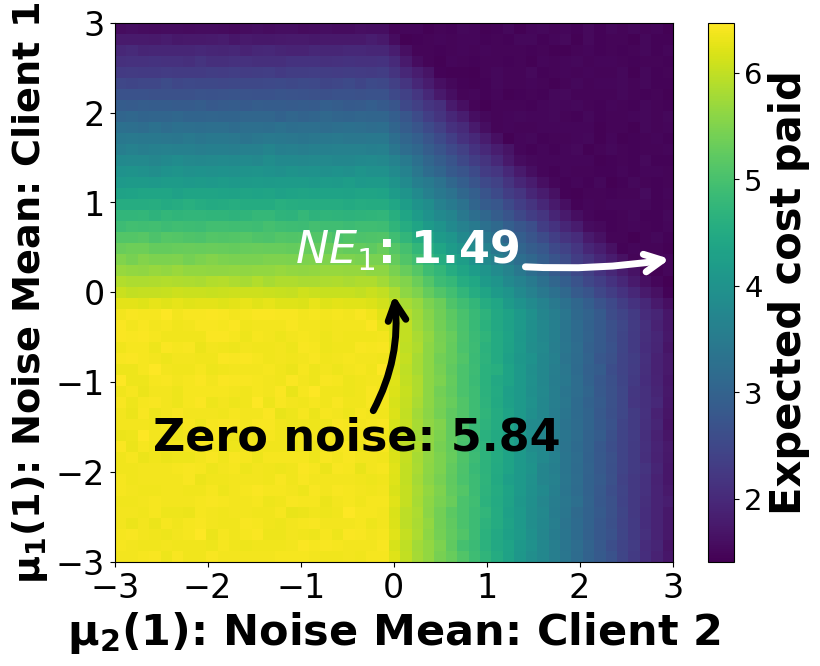

In [43]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(data, x_ticks, y_ticks, title, xlabel, ylabel, NE_pairs):
    plt.figure(figsize=(9, 7))
    im = plt.imshow(data, cmap='viridis', interpolation='nearest', origin='lower',
                    extent=[x_ticks[0], x_ticks[-1], y_ticks[0], y_ticks[-1]], aspect='auto')

    # Create colorbar with larger font
    cbar = plt.colorbar(im)
    cbar.set_label('Expected cost paid', size=30,weight='bold')  # Adjust size as needed
    cbar.ax.tick_params(labelsize=21)  # Adjust tick size as needed

    # Set larger fonts for labels and title
    plt.xlabel(xlabel, fontsize=31,weight='bold')
    plt.ylabel(ylabel, fontsize=27.5,weight='bold')

    # Increase tick size
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Annotate (0,0) specifically
    zero_index_x = np.argmin(np.abs(np.array(x_ticks)))
    zero_index_y = np.argmin(np.abs(np.array(y_ticks)))
    value_at_zero = data[zero_index_y, zero_index_x]

    plt.annotate(f'Zero noise: {value_at_zero:.2f}', xy=(0, 0), xytext=(+120, -120),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='Black', linewidth=5),
                 ha='right', va='bottom', fontsize=32, color='Black', fontweight='bold')

    # Annotate Nash Equilibrium (NE) pairs with adjusted positions
    ne_text_offsets = [(-110, -10), (-110, -10), (-150, -0)]  # Different offsets for each NE point
    for i, (ne_x, ne_y) in enumerate(NE_pairs):
        index_x = np.argmin(np.abs(np.array(x_ticks) - ne_x))
        index_y = np.argmin(np.abs(np.array(y_ticks) - ne_y))
        value_at_ne = data[index_y, index_x]
        offset = ne_text_offsets[i % len(ne_text_offsets)]
        plt.annotate(f'$NE_{i+1}$: {value_at_ne:.2f}', xy=(ne_x, ne_y), xytext=offset,
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.1", color='White', linewidth=5),
                     ha='right', va='bottom', fontsize=32, color='White', fontweight='bold')

    plt.grid(False)  # Turn off the grid
    plt.show()

def find_nash_equilibria(expected_costs_1, expected_costs_2, means1, means2):
    NE_pairs = []
    n, m = expected_costs_1.shape
    for i in range(n):
        for j in range(m):
            # Finding the best response for client 1 for a fixed strategy of client 2
            best_response_1 = expected_costs_1[:, j].argmin()
            # Finding the best response for client 2 for a fixed strategy of client 1
            best_response_2 = expected_costs_2[i, :].argmin()

            # If the best response for each client corresponds to the current strategy pair, it is a NE
            if best_response_1 == i and best_response_2 == j:
                NE_pairs.append((float(means1[i]), float(means2[j])))

    return NE_pairs

NE_pairs = find_nash_equilibria(expected_costs_1, expected_costs_2, means1, means2)
print("Nash Equilibrium pairs (mean1, mean2):")
for pair in NE_pairs:
    print(pair)

plot_heatmap(expected_costs_2, means1, means2,
             title=r'Expected Cost Paid by Client 1 ($\mathbf{-\mathbb{E}(u_1)}$)',
             xlabel=r'$\mathbf{\mu_2(1)}$: Noise Mean: Client 2',
             ylabel=r'$\mathbf{\mu_1(1)}$: Noise Mean: Client 1',NE_pairs=NE_pairs)

